<a href="https://colab.research.google.com/github/infomon/understanding_cnn/blob/master/notebooks/Compare_methods_on_ImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Qualitative analysis of ImageNet images

This notebook shows how saliency maps are computed for various methods on the ImageNet dataset. We will use a pretrained VGG 16 from Keras Applications and then apply different methods. In the end all visualizations are put into one grid

## Imports

In [0]:
!pip install scipy==1.2.0
!pip install -q git+https://github.com/albermax/innvestigate
!pip install wget
!git clone https://github.com/infomon/understanding_cnn
import shutil
import os
if not os.path.isfile("utils.py"):
  shutil.move("/content/understanding_cnn/utils/utils.py", "/content")
if not os.path.isfile("utils_imagenet.py"):
  shutil.move("/content/understanding_cnn/utils/utils_imagenet.py", "/content")
if not os.path.isdir("models"):
  shutil.move("/content/understanding_cnn/models", "/content")
if not os.path.isdir("images"):
  shutil.move("/content/understanding_cnn/data/images", "/content")
if not os.path.isfile("data_loader.py"):
  shutil.move("/content/understanding_cnn/data/data_loader.py", "/content")
  
!rm -r understanding_cnn

Cloning into 'understanding_cnn'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 237 (delta 6), reused 0 (delta 0), pack-reused 221
Receiving objects: 100% (237/237), 28.28 MiB | 10.15 MiB/s, done.
Resolving deltas: 100% (109/109), done.


In [0]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

In [0]:
%matplotlib inline  

import imp
import numpy as np
import os

import keras

import innvestigate
import innvestigate.applications.imagenet
import innvestigate.utils as iutils

eutils = imp.load_source("utils", "utils.py")
imgnetutils = imp.load_source("utils_imagenet", "utils_imagenet.py")

import models.model_loader as model_loader
import data_loader

Using TensorFlow backend.
W0407 11:41:29.281089 139690261288832 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


## Model

In this demo use the VGG16-model, which uses ReLU activation layers.

In [0]:
model = model_loader.VGG16()

Instructions for updating:
Colocations handled automatically by placer.


W0407 11:41:29.362654 139690261288832 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


## Data

Now we load some example images and preprocess them to fit the input size model.

## Analysis

In [0]:
# Get some example test set images.
images = []
data = data_loader.load_from_folder("images",model.get_image_size())
label_to_class_name = []
for img,label in data:
  images.append(img)
  label_to_class_name.append(label)

In [0]:
patterns = model.get_patterns()
input_range = (-1,1)

noise_scale = (input_range[1]-input_range[0]) * 0.1

# Methods we use and some properties.
methods = [
        # NAME                    OPT.PARAMS                POSTPROC FXN                TITLE
        # Show input.
        ("input",                 {},                       imgnetutils.image,         "Input"), #0

        # Function
        ("gradient",              {"postprocess": "abs"},   imgnetutils.graymap,       "Gradient"), #1
        ("smoothgrad",            {"augment_by_n": 16,
                                   "noise_scale": noise_scale,
                                   "postprocess": "square"},imgnetutils.graymap,       "SmoothGrad"), #2

        # Signal
        ("deconvnet",             {},                       imgnetutils.bk_proj,       "Deconvnet"), #3
        ("guided_backprop",       {},                       imgnetutils.bk_proj,       "Guided Backprop",), #4
        ("pattern.net",           {"patterns": patterns},   imgnetutils.bk_proj,       "PatternNet"), #5

        # Interaction
        ("pattern.attribution",   {"patterns": patterns},   imgnetutils.heatmap,       "PatternAttribution"), #6
        ("deep_taylor.bounded",   {"low": input_range[0],
                                   "high": input_range[1]}, imgnetutils.heatmap,       "DeepTaylor"), #7
        ("input_t_gradient",      {},                       imgnetutils.heatmap,       "Input * Gradient"), #8
        ("integrated_gradients",  {"reference_inputs": input_range[0],
                                   "steps": 16},            imgnetutils.heatmap,       "Integrated Gradients"), #9
        ("lrp.epsilon",           {"epsilon": 1},           imgnetutils.heatmap,        "LRP-Epsilon"), #10
        ("lrp.epsilon_IB",           {"epsilon": 1},           imgnetutils.heatmap,        "LRP-Epsilon IB"), #11
        ("lrp.alpha_1_beta_0",           {},           imgnetutils.heatmap,        "LRP-Alpha1-Beta0"), #12
        ("lrp.alpha_1_beta_0_IB",           {},           imgnetutils.heatmap,        "LRP-Alpha1-Beta0 IB"), #13
        ("lrp.sequential_preset_a_flat",{"epsilon": 1},     imgnetutils.heatmap,       "LRP-PresetAFlat"), #14
      ("lrp.sequential_preset_b_flat",{"epsilon": 1},     imgnetutils.heatmap,       "LRP-PresetBFlat"), #15
    ]

The main loop below will now instantiate the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above and compute the analyses.

In [0]:
# Create model without trailing softmax
model_wo_softmax = model.get_model()

# Create analyzers.
analyzers = []
for method in methods:
    try:
        analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                                model_wo_softmax, # model without softmax output
                                                **method[1])      # optional analysis parameters
    except innvestigate.NotAnalyzeableModelException:
        # Not all methods work with all models.
        analyzer = None
    analyzers.append(analyzer)

Now we analyze each image with the different analyzers:

In [0]:
analysis = np.zeros([len(images), len(analyzers)]+list(model.get_image_size())+[3])
text = []

channels_first = keras.backend.image_data_format() == "channels_first"
color_conversion = "BGRtoRGB" if model.get_color_coding() == "BGR" else None


for i,x in enumerate(images):
    print("Image " + str(i+1) + " of " + str(len(images)))
  
  
    # Add batch axis.
    x = x[None, :, :, :]
    x_pp = model.preprocess_input(x)

    # Predict final activations, probabilites, and label.
    presm = model.predict_wo_softmax(x_pp)[0]
    prob = model.predict_with_softmax(x_pp)[0]
    y_hat = prob.argmax()
    
    # Save prediction info:
    text.append(("%s" % label_to_class_name[i],    # ground truth label
                 "%.2f" % presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),              # probabilistic softmax output  
                 "%s" % model.decode_predictions(prob[None,...], top=1)[0][0][1] # predicted label
                ))

    for aidx, analyzer in enumerate(analyzers):
        print(methods[aidx][3])
        if methods[aidx][0] == "input":
            # Do not analyze, but keep not preprocessed input.
            a = x/255
        elif analyzer:
            # Analyze.
            a = analyzer.analyze(x_pp)

            # Apply common postprocessing, e.g., re-ordering the channels for plotting.
            a = imgnetutils.postprocess(a, color_conversion, channels_first)
            # Apply analysis postprocessing, e.g., creating a heatmap.
            a = methods[aidx][2](a)
        else:
            a = np.zeros_like(image)
        # Store the analysis.
        analysis[i, aidx] = a[0]
    print('Finished analyzing')

Image 1 of 10
Input
Gradient
Instructions for updating:
Use tf.cast instead.


W0407 11:41:36.996987 139690261288832 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0407 11:41:37.020539 139690261288832 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


SmoothGrad
Deconvnet
Guided Backprop
PatternNet
PatternAttribution
DeepTaylor
Input * Gradient
Integrated Gradients
LRP-Epsilon
LRP-Epsilon IB
LRP-Alpha1-Beta0
LRP-Alpha1-Beta0 IB
LRP-PresetAFlat
LRP-PresetBFlat
Finished analyzing
Image 2 of 10
Input
Gradient
SmoothGrad
Deconvnet
Guided Backprop
PatternNet
PatternAttribution
DeepTaylor
Input * Gradient
Integrated Gradients
LRP-Epsilon
LRP-Epsilon IB
LRP-Alpha1-Beta0
LRP-Alpha1-Beta0 IB
LRP-PresetAFlat
LRP-PresetBFlat
Finished analyzing
Image 3 of 10
Input
Gradient
SmoothGrad
Deconvnet
Guided Backprop
PatternNet
PatternAttribution
DeepTaylor
Input * Gradient
Integrated Gradients
LRP-Epsilon
LRP-Epsilon IB
LRP-Alpha1-Beta0
LRP-Alpha1-Beta0 IB
LRP-PresetAFlat
LRP-PresetBFlat
Finished analyzing
Image 4 of 10
Input
Gradient
SmoothGrad
Deconvnet
Guided Backprop
PatternNet
PatternAttribution
DeepTaylor
Input * Gradient
Integrated Gradients
LRP-Epsilon
LRP-Epsilon IB
LRP-Alpha1-Beta0
LRP-Alpha1-Beta0 IB
LRP-PresetAFlat
LRP-PresetBFlat
Finished

Next, we visualize the analysis results:

<Figure size 432x288 with 0 Axes>

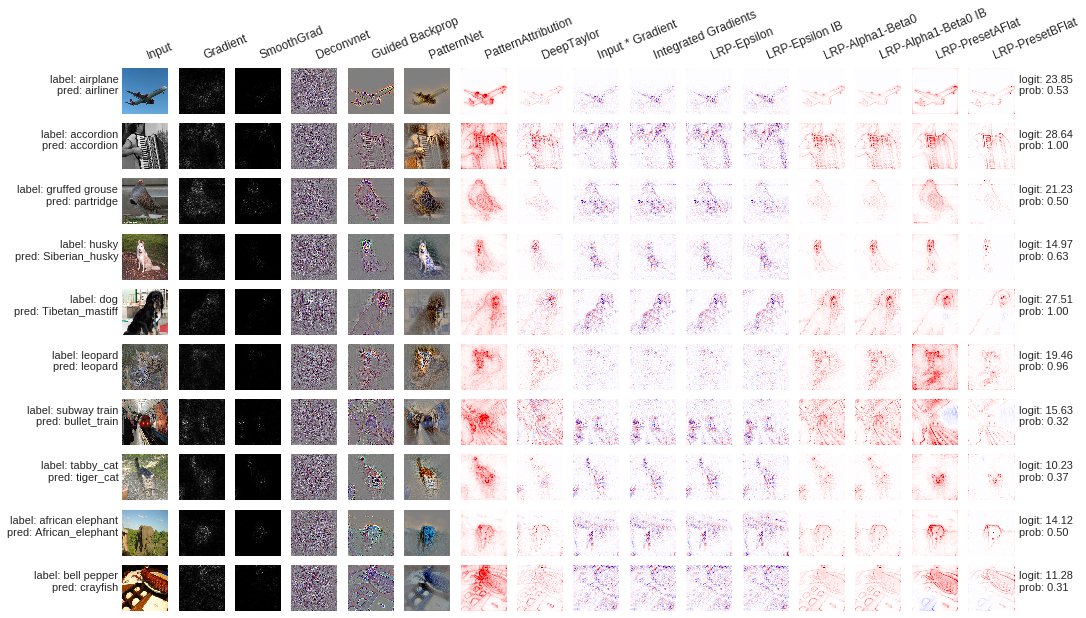

In [0]:
# Prepare the grid as rectengular list
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]  
# Prepare the labels
label, presm, prob, pred = zip(*text)
row_labels_left = [('label: {}'.format(label[i]),'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]),'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]

# Plot the analysis.
eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                       file_name=os.environ.get("plot_file_name", None))

This figure shows the analysis regarding the *actually predicted* class as computed by the selected analyzers. Each column shows the visualized results for different analyzers and each row shows the analyses wrt to one input sample. To the left of each row, the ground truth label `label` and the predicted label `pred` are show. To the right, the model's probabilistic (softmax) output is shown as `prob` and the logit output just before the terminating softmax layer as `logit`. Note that all analyses have been performed based on the logit output (layer).


If you are curious about how **iNNvestigate** performs on *different* ImageNet model, have a look here: [Comparing networks on ImageNet](imagenet_network_comparison.ipynb)